In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import string
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score,train_test_split
import math
import spacy
import en_core_web_sm
import itertools
from sklearn.metrics import mean_squared_error
from pymagnitude import *

In [2]:
vectors = Magnitude('./GoogleNews-vectors-negative300.magnitude')

In [3]:
df_train = pd.read_csv('train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1")
df_attr = pd.read_csv('attributes.csv')
df_pro_desc = pd.read_csv('product_descriptions.csv')
#df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_train_desc = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')
df_train_small = df_train_desc
df_train_small

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00,"Atlantic, Inc. 94835722 Uniquely designed for ..."
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00,Philips Energy Advantage lamps use less energy...
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33,The Schlage Camelot In-Active Aged Bronze Hand...
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00,The Rose Garden is inspired by the popular ear...


In [4]:
def clean_text(text):
    stopwords = nltk.corpus.stopwords.words('english')
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

df_train_small['product_title'] = df_train_small['product_title'].apply(lambda x: clean_text(x.lower()))
df_train_small['search_term'] = df_train_small['search_term'].apply(lambda x: clean_text(x.lower()))
df_train_small['product_description'] = df_train_small['product_description'].apply(lambda x: clean_text(x.lower()))
df_train_small

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,"[simpson, strongtie, 12gauge, angle]","[angle, bracket]",3.00,"[angles, make, joints, stronger, also, provide..."
1,3,100001,"[simpson, strongtie, 12gauge, angle]","[l, bracket]",2.50,"[angles, make, joints, stronger, also, provide..."
2,9,100002,"[behr, premium, textured, deckover, 1gal, sc14...",[deck],3.00,"[behr, premium, textured, deckover, innovative..."
3,16,100005,"[delta, vero, 1handle, shower, faucet, trim, k...","[rain, shower, head]",2.33,"[update, bathroom, delta, vero, singlehandle, ..."
4,17,100005,"[delta, vero, 1handle, shower, faucet, trim, k...","[shower, faucet]",2.67,"[update, bathroom, delta, vero, singlehandle, ..."
...,...,...,...,...,...,...
74062,221457,206638,"[atlantic, windowpane, 576, cd, 192, dvd, blur...","[tv, riser, glass]",1.00,"[atlantic, inc, 94835722, uniquely, designed, ..."
74063,221458,206639,"[philips, 40watt, halogen, r20, flood, light, ...","[r20, halogen, light]",3.00,"[philips, energy, advantage, lamps, use, less,..."
74064,221463,206641,"[schlage, camelot, inactive, aged, bronze, han...","[schlage, lock, siena, half, dummy, knob]",2.33,"[schlage, camelot, inactive, aged, bronze, han..."
74065,221471,206648,"[plastec, 11, x, 24, rose, garden, wall, decor...","[zen, garden, decor]",3.00,"[rose, garden, inspired, popular, early, 20th,..."


In [ ]:
#stemming
ps = nltk.PorterStemmer() # define stemmer
df_all_stem = pd.DataFrame()

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]  #return stemmed word
    return text
df_all_stem['id'] = df_train_small['id']
df_all_stem['product_uid'] = df_train_small['product_uid']
df_all_stem['product_title'] = df_train_small['product_title'].apply(lambda x: stemming(x))
df_all_stem['search_term'] = df_train_small['search_term'].apply(lambda x: stemming(x))
df_all_stem['product_description'] = df_train_small['product_description'].apply(lambda x: stemming(x))
df_all_stem['relevance'] = df_train_small['relevance']
df_all_stem.head()

In [ ]:
df_all_stem.info()

## Use customized embedding techinique - mean of similarities

In [ ]:
def sim_score(sim_vec):
    sim_score = []
    for a in sim_vec:
        mean = np.mean(a) 
        sim_score.append(mean)
    return np.mean(sim_score) 

def get_sim_score(A,B):
    #A,B are lists of 
    sim_score_list = []
    for i in range(len(A)):
        #print(B[i])
        try:
            sim_score_list.append(sim_score(vectors.similarity(A[i],B[i])))
        except:
            print(B[i])
            sim_score_list.append(0) #if one of the list is empty, means no word in it. Return 0 similarity
    return sim_score_list

### embedding Product title, get similarity score between product title and search_term


In [8]:
df_emb = pd.DataFrame()
product_title_emb = get_sim_score(list(df_all_stem['product_title']),list(df_all_stem['search_term']))
df_emb['title_sim'] = product_title_emb
df_emb

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


,title_sim
0,0.099485
1,0.056404
2,0.043307
3,0.036266
4,0.077293
...,...
74062,0.040757
74063,0.090597
74064,0.034847
74065,0.060843


In [9]:
description_emb = get_sim_score(list(df_all_stem['product_description']),list(df_all_stem['search_term']))
df_emb['description_sim'] = description_emb
df_emb

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


,title_sim,description_sim
0,0.099485,0.011724
1,0.056404,0.009350
2,0.043307,0.011489
3,0.036266,0.009092
4,0.077293,0.016911
...,...,...
74062,0.040757,0.013468
74063,0.090597,0.014838
74064,0.034847,0.007674
74065,0.060843,0.025619


In [10]:
df_emb.to_csv("HD_embedding.csv")

## Add new features

In [11]:
df_all_features = pd.DataFrame()

def str_common_word(list1, list2):
    list3 = set(list1)&set(list2) 
    list4 = sorted(list3, key = lambda k : list1.index(k))
    return len(list4)


df_all_features['search_term'] = df_all_stem['search_term']
df_all_features['product_title'] = df_all_stem['product_title']
df_all_features['product_description'] = df_all_stem['product_description']

df_all_features['product_info'] = df_all_features.values.tolist()
df_all_features['id'] = df_train_small['id']
df_all_features['product_uid'] = df_train_small['product_uid']
df_all_features['len_of_query'] = df_all_features['search_term'].map(lambda x:len(x)).astype(np.int64)
df_all_features['word_in_title'] = df_all_features['product_info'].map(lambda x:str_common_word(x[0],x[1]))
df_all_features['word_in_description'] = df_all_features['product_info'].map(lambda x:str_common_word(x[0],x[2]))
df_all_features = df_all_features.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_all_features.head()

,id,product_uid,len_of_query,word_in_title,word_in_description
0,2,100001,2,1,1
1,3,100001,2,0,0
2,9,100002,1,0,1
3,16,100005,3,1,1
4,17,100005,2,2,2


In [12]:
#add the embedding features
df_all_features_emb = pd.concat([df_all_features, df_emb], axis=1)
df_all_features_emb['relevance'] = df_train_small['relevance']
df_all_features_emb

,id,product_uid,len_of_query,word_in_title,word_in_description,title_sim,description_sim,relevance
0,2,100001,2,1,1,0.099485,0.011724,3.00
1,3,100001,2,0,0,0.056404,0.009350,2.50
2,9,100002,1,0,1,0.043307,0.011489,3.00
3,16,100005,3,1,1,0.036266,0.009092,2.33
4,17,100005,2,2,2,0.077293,0.016911,2.67
...,...,...,...,...,...,...,...,...
74062,221457,206638,3,1,1,0.040757,0.013468,1.00
74063,221458,206639,3,3,2,0.090597,0.014838,3.00
74064,221463,206641,6,1,1,0.034847,0.007674,2.33
74065,221471,206648,3,2,2,0.060843,0.025619,3.00


## check the distribution of the features

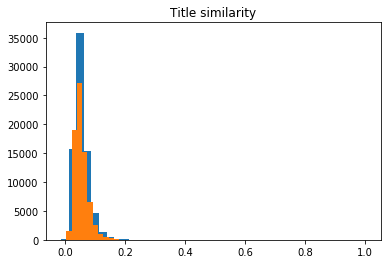

In [33]:
pyplot.hist(df_all_features_emb['title_sim'], bins = 40)
pyplot.title("Title similarity")
df_all_features_emb['title_sim_log'] = (df_all_features_emb['title_sim']+1).transform(np.log)
pyplot.hist(df_all_features_emb['title_sim_log'], bins = 40)
pyplot.show()

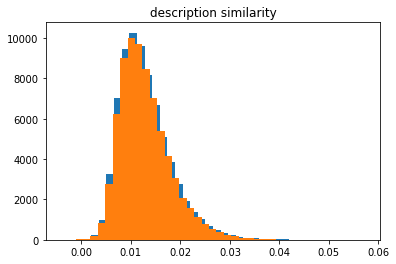

In [34]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline
df_all_features_emb['description_sim_log'] = (df_all_features_emb['description_sim']+1).transform(np.log)
pyplot.hist(df_all_features_emb['description_sim'], bins = 40)
pyplot.hist(df_all_features_emb['description_sim_log'], bins = 40)
pyplot.title("description similarity")
pyplot.show()

## Build Models

In [35]:
X = df_all_features_emb.drop(['id','product_uid','relevance','description_sim','title_sim'],axis=1)
y = df_all_features_emb['relevance'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)

clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

#out of sample result
print(math.sqrt(mean_squared_error(y_test, y_pred_clf)))

0.4876723648021967


In [37]:
#in-sample result
CV_score_clf = cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
math.sqrt(-CV_score_clf.mean())

0.48906441886591157

In [38]:
#Random forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_rf)))

0.48785673614523867


In [39]:
CV_score_rf = cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
math.sqrt(-CV_score_rf.mean()) #root mean squared error

0.48906441886591157

In [17]:
#xgboost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,max_depth = 5)
xg_reg.fit(X_train,y_train)
#preds = xg_reg.predict(X_test_stand)
#preds
CV_score_XGB = cross_val_score(xg_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
math.sqrt(-CV_score_XGB.mean())

0.4880092511209217

In [18]:
y_pred_xg = xg_reg.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_xg)))

0.4863416194413129


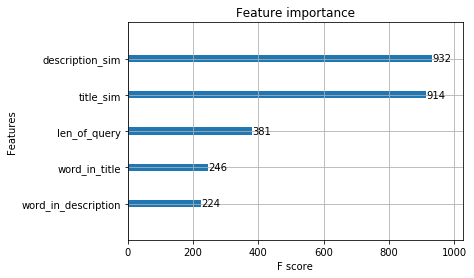

In [19]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(xg_reg)
plt.show() 
#feature 3 and 4 are the embedding features
#the result is slightly better then just using simple features. And it's much better then normal word2vec embedding

In [20]:
#try other models
import lightgbm
mod_lgbm = lightgbm.LGBMRegressor(max_depth=3,learning_rate=0.1)
mod_lgbm.fit(X_train,y_train)
LGBM_preds=mod_lgbm.predict(X_test)

cv_scores_lgbm = cross_val_score(mod_lgbm, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

math.sqrt(-cv_scores_lgbm.mean())

0.4882557489211037

In [21]:
print(math.sqrt(mean_squared_error(y_test, LGBM_preds)))

0.48702820004133246


In [7]:
#test the similarity function
vectors.similarity(['Simpson','Strong-Tie', 'Angle'],['angle', 'bracket'])

[array([ 0.01038651, -0.01440274,  0.13343188], dtype=float32),
 array([0.01308307, 0.01708629, 0.04740979], dtype=float32)]